In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d7745f32ca17ea4764f4275bf892b00998740266b027a75b1e42d764398fe0d0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
# import necessary library
import numpy as np 
import pandas as pd 
import torch 
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, utils 
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torch import nn 
import torch.nn.functional  as F
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from skimage.util import img_as_ubyte

In [4]:
# define some paths
load_dir = "/kaggle/input/hpa-single-cell-image-classification/"
test_paths = load_dir + "test/"
train_paths = load_dir + "train/"
sub_df = pd.read_csv('../input/hpa-single-cell-image-classification/sample_submission.csv')
sub_df

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==
...,...,...,...,...
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,0 1 eNoLCAjJNgIABNkBkg==
555,feb955db-6c07-4717-a98b-92236c8e01d8,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
556,fefb9bb7-934a-40d1-8d2f-210265857388,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
557,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [5]:
# create an empty dadaframe of testing result
sub_df = sub_df.drop(sub_df.columns[1:],axis=1)
for i in range(19):
    sub_df[f'{i}'] = pd.Series(np.zeros(sub_df.shape[0]))
sub_df

,ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,004a270d-34a2-4d60-bbe4-365fca868193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00537262-883c-4b37-a3a1-a4931b6faea5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0173029a-161d-40ef-af28-2342915b22fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555,feb955db-6c07-4717-a98b-92236c8e01d8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,fefb9bb7-934a-40d1-8d2f-210265857388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,ff069fa2-d948-408e-91b3-034cfea428d1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# get the column index of the result dataframe
label_cols = sub_df.columns[1:]
label_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18'],
      dtype='object')

In [7]:
# change the test data type to uint8 
def normalize8(I):
    mn = I.min()
    mx = I.max()

    mx -= mn

    I = ((I - mn)/mx) * 255
    return I.astype(np.uint8)

In [8]:
# class of dataset using yellow, blue and red images
class HPADatasetTest(Dataset):
    
    def __init__(self, images_path, image_ids, transform):
        super().__init__()
        self.transform = transform
        self.images_path = images_path
        self.image_ids = image_ids
        # change here to test different channels of images
        self.filters = ['red', 'green', 'blue']
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_ids = self.image_ids[idx]
        images_path = [os.path.join(self.images_path,str(image_ids)+"_"+color+".png") for color in self.filters]
        images = [np.asarray(Image.open(img)) for img in images_path]
        images = [normalize8(img) for img in images]
        images = np.concatenate([np.expand_dims(img,-1) for img in images],axis=-1)
        images = Image.fromarray(images)
        images = self.transform(images) 
        return {
            "images": images,
        }

In [9]:
# transform image
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),])

# create the testing dataloader
def dataloader(batchsize):

    test_dataset = HPADatasetTest(images_path=test_paths,
                                   image_ids=sub_df.ID.values,
                                    transform = transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=4)
    
    return test_dataloader

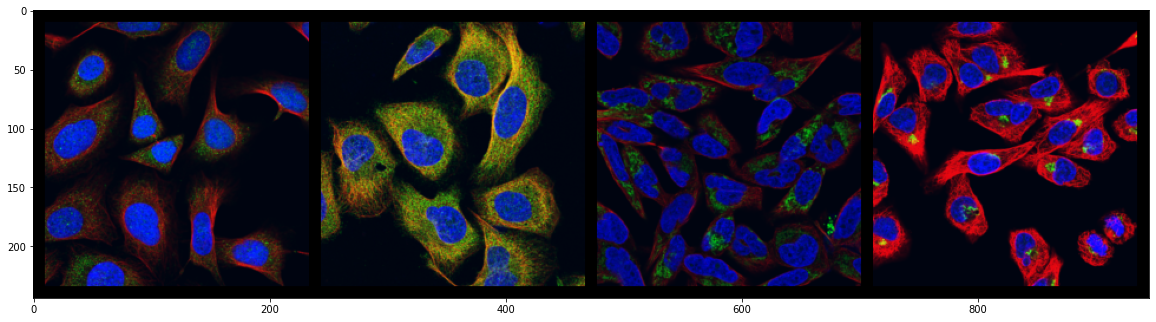

In [10]:
# show example images
data_loader = dataloader(4)
data = next(iter(data_loader))

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 50))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
show(utils.make_grid(data["images"], padding=10,normalize=True))

In [11]:
# load the efficient and change the output dimension to 19
model = EfficientNet.from_pretrained('efficientnet-b0')
feature = model._fc.in_features
# labels are 19 dimension
model._fc = nn.Linear(in_features=feature,out_features=19,bias=True)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [12]:
# load the trained model weights
device = torch.device('cuda')
# change here to use different model weights at different epochs training
#weight = torch.load('/kaggle/input/efficientnet-ybr/efficientnet_ybr/HPA_efficientnet_10ep.pth', map_location=device)

# the best performance model weight at epoch=9
weight = torch.load('/kaggle/input/efficientnet-rgb/efficientnet_rgb/HPA_efficientnet_9ep.pth', map_location=device)
weight = weight['model_state_dict']

In [13]:
# update the models weights
model.load_state_dict(weight)
model.state_dict()
model = model.to(device)

In [14]:
# create test dataloader
test_dataloader = dataloader(batchsize=1)
ori_lst = []

In [15]:
# create some empty output list
ori_cpu_lst = []
sig_lst = []
lab_lst = []

In [16]:
# get the output using testing images
with torch.no_grad():
    for data in tqdm(test_dataloader, total=len(test_dataloader)):
        model.eval()
        images = data["images"].to(device)
        out = model(images)
        ori_lst.append(out)

100%|██████████| 559/559 [02:56<00:00,  3.17it/s]


In [17]:
# original output
ori_lst

[tensor([[-1.0268, -6.7141, -1.4019, -0.8905, -5.7068, -3.9073, -2.5616, -5.5617,
          -4.9385, -4.3647, -7.7647, -9.9434, -6.6805, -5.3739, -1.7364, -6.9631,
           1.6445, -1.5742, -6.6522]], device='cuda:0'),
 tensor([[ -7.2045,  -4.4249, -11.8167, -11.1572,  -7.5819,  -9.0775,  -5.9228,
           -8.9391,  -7.9099,  -6.4139,   2.1792,  -4.6829,  -7.2992,  -0.0848,
           -9.4077,  -9.7347,   3.3669,  -8.7545,  -9.2826]], device='cuda:0'),
 tensor([[ -9.6232, -13.5846, -16.9230, -16.1668, -15.7119, -11.6786, -10.4427,
          -13.8045, -12.6754, -17.5842, -15.4983, -16.2973, -12.8150, -15.7507,
            7.5985, -16.3051, -11.0532, -11.0974, -16.1308]], device='cuda:0'),
 tensor([[ -6.3654, -11.5028, -10.4143,  -6.0341,  -8.4239,  -5.6260,  -7.3885,
           10.5279,  -5.0434, -11.7992,  -8.3555, -14.7728,  -7.4463, -13.4351,
          -11.8526, -11.3088, -11.6307, -12.8466, -13.8856]], device='cuda:0'),
 tensor([[ -1.7150, -11.6259,  -8.9305,  -9.0754,  -7.0475,

In [18]:
# get the original output, sigmoid output, label output
ori_cpu_lst = [out.cpu().detach().numpy() for out in ori_lst]
sig_lst = [torch.sigmoid(out.cpu().detach()).numpy() for out in ori_lst]
lab_lst = [np.round(torch.sigmoid(out.cpu().detach()).numpy()) for out in ori_lst]

In [19]:
# copy the result dataframe
sub_df_ori = sub_df.copy()
sub_df_sig = sub_df.copy()
sub_df_lab = sub_df.copy()

In [20]:
# create dataframe of original output, sigmoid output, label output
sub_df_ori[label_cols] = pd.DataFrame(np.squeeze(ori_cpu_lst))
sub_df_sig[label_cols] = pd.DataFrame(np.squeeze(sig_lst))
sub_df_lab[label_cols] = pd.DataFrame(np.squeeze(lab_lst))

In [21]:
# save to csv file
sub_df_ori.to_csv('original_output_rgb.csv',index = False)
sub_df_sig.to_csv('sigmoid_output_rgb.csv',index = False)
sub_df_lab.to_csv('label_output_rgb.csv',index = False)